In [3]:
''' This script trains a score-based model to learn a score function with the built-in singularity.'''

## Importing necessary libraries
import torch, random, shutil, os, numpy as np, torch.nn as nn
import matplotlib.pyplot as plt
from ema_pytorch import EMA

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting up the plotting parameters
plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif",'font.size': 18})

## Load data

<Figure size 200x200 with 0 Axes>

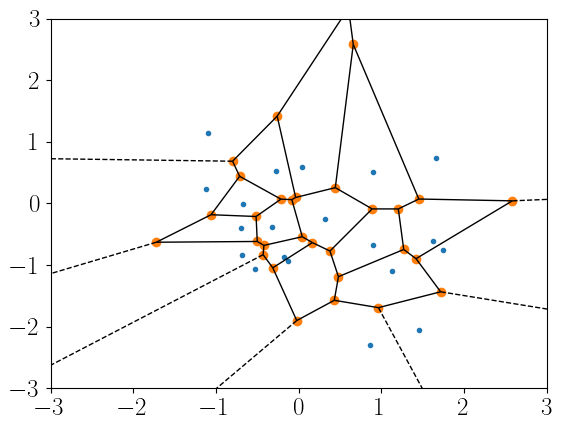

In [4]:
# Set seed manually for reproducibility
random.seed(1)
np.random.seed(1)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load data
data = torch.from_numpy(np.load("training_data.npy")).float()
N = data.shape[0]
dim = data.shape[1]

# plot data
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(data)
plt.figure(figsize=(2,2))
fig = voronoi_plot_2d(vor)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

## Define model

In [5]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class score_edm(torch.nn.Module):
    '''
        Neural network to learn the score function
        Results in the paper use the default settings of width=256, depth=2, activation=ReLU
    '''
    def __init__(self, device, width=256, depth=2, embed_dim=8, activation=nn.ReLU, schedule=None):
        super().__init__()
        
        self.width = width
        self.depth = depth
        self.activation = activation()
        self.embed = GaussianFourierProjection(embed_dim, scale=1.0)
        net = []
        net.append(nn.Linear(2+embed_dim,self.width))
        net.append(self.activation)
        for _ in range(self.depth):
            net.append(nn.Linear(self.width,self.width))
            net.append(self.activation)
        net.append(nn.Linear(self.width,2))
        self.net = nn.Sequential(*net).to(device=device)
        self.training_mode = True
        self.schedule = schedule
        
    def forward(self, x, t):
        embed = self.embed(t.squeeze())
        x_in = torch.cat([x, embed], dim=-1)
        score = self.net(x_in).to(torch.float32)
        if self.training_mode == False:
            score = score / schedule.marginal_prob_std(t)[:,None]
        return score
    
def loss_func(net, X, schedule, denoising=False):
    '''
        Denoising score matching loss function (un-regularized)
    '''
    t = torch.rand([X.shape[0], 1], device=X.device)
    noise = torch.randn_like(X) 
    mean = (schedule.marginal_prob_mean(t)).to(X.device)
    std  = (schedule.marginal_prob_std(t)).to(X.device)
    x_tilde = mean * X + std * noise
    score = net(x_tilde, t)
    if denoising == True:
        loss = torch.mean((score + noise)**2, dim=(1))
    else:
        loss = torch.mean((std*score + noise)**2, dim=(1))
    return loss.mean()

from score_models import GMM_score, VE, VP

# Training parameters
n_epochs        = 100000 # maximum number of total epochs
lr              = 1e-3   # learning rate
width           = 256    # Width of the score network 
depth           = 2      # Depth of the score network
plot_every      = 10000  # Plotting interval
embed_dim       = 8      # Dimension of the time embedding
path_to_save    = './experiments/Singularity/'
figures_path    = './figures/VP_NN_Singularity/'

# define schedule
schedule = VP() 
#schedule = VE()

## Train networks

In [6]:
# Define network for non-denoising loss
score_net = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
score_ema = EMA(score_net, beta=0.9999)

# define optimizer
optimizer = torch.optim.Adam(score_net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Training loop for non-denoising loss
for epoch in range(n_epochs):
    score_net.train()

    # shuffle data
    X = data.to(device) 
    X = X[torch.randperm(X.shape[0])]

    # evaluate loss and backpropagate
    loss = loss_func(score_net, X, schedule, denoising=False)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    score_ema.update()
        
    # save results
    if (epoch+1) % plot_every == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))
        states = [score_net.state_dict(),score_ema.state_dict(),optimizer.state_dict()]
        torch.save(states, path_to_save+'nonsingular_checkpoint_'+str(epoch)+'.pth')

# Define network for denoising loss
score_net_singular = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
score_ema_singular = EMA(score_net_singular, beta=0.9999)

# define optimizer
optimizer_singular = torch.optim.Adam(score_net_singular.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Training loop for non-denoising loss
for epoch in range(n_epochs):
    score_net.train()

    # shuffle data
    X = data.to(device) 
    X = X[torch.randperm(X.shape[0])]

    # evaluate loss and backpropagate
    loss = loss_func(score_net_singular, X, schedule, denoising=True)
    optimizer_singular.zero_grad()
    loss.backward()

    optimizer_singular.step()
    score_ema_singular.update()
        
    # save results
    if (epoch+1) % plot_every == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))
        states = [score_net_singular.state_dict(),score_ema_singular.state_dict(),optimizer_singular.state_dict()]
        torch.save(states, path_to_save+'singular_checkpoint_'+str(epoch)+'.pth')

epoch: 9999, loss: 0.794059157371521
epoch: 19999, loss: 0.47033485770225525
epoch: 29999, loss: 0.5660445094108582
epoch: 39999, loss: 0.34458819031715393
epoch: 49999, loss: 0.4034510552883148
epoch: 59999, loss: 0.3890027701854706
epoch: 69999, loss: 0.47709932923316956
epoch: 79999, loss: 0.6871669888496399
epoch: 89999, loss: 0.6463720202445984
epoch: 99999, loss: 0.6063981652259827
epoch: 9999, loss: 0.6146014332771301
epoch: 19999, loss: 0.4551634192466736
epoch: 29999, loss: 0.6144270896911621
epoch: 39999, loss: 0.6568549871444702
epoch: 49999, loss: 0.6212442517280579
epoch: 59999, loss: 0.6600238084793091
epoch: 69999, loss: 0.46715134382247925
epoch: 79999, loss: 0.3218466341495514
epoch: 89999, loss: 0.3105483949184418
epoch: 99999, loss: 0.2127503603696823


## Generate samples

/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_36601/2214133244.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)
/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_36601/2214133244.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

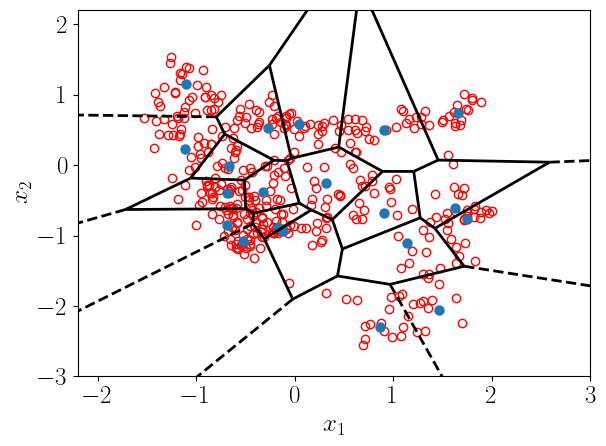

<Figure size 640x480 with 0 Axes>

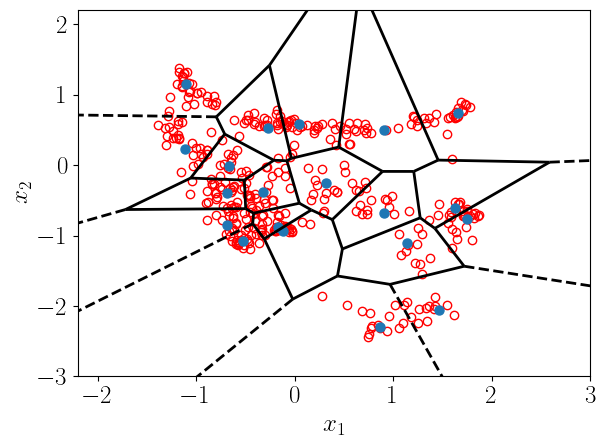

<Figure size 640x480 with 0 Axes>

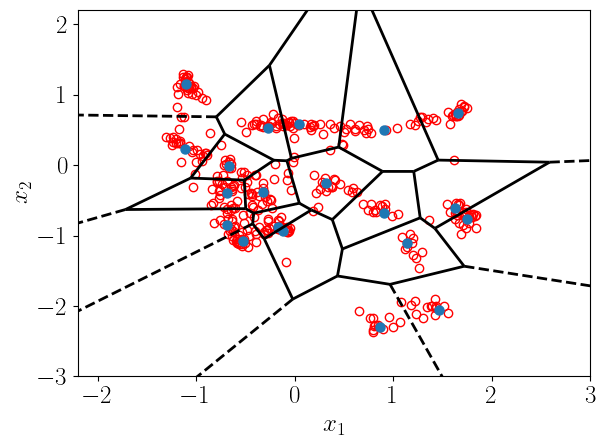

<Figure size 640x480 with 0 Axes>

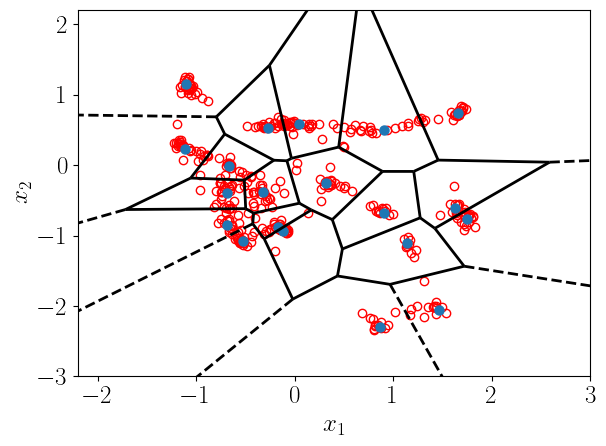

<Figure size 640x480 with 0 Axes>

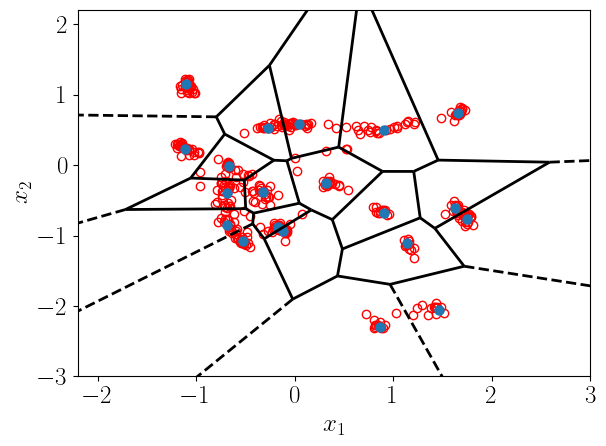

<Figure size 640x480 with 0 Axes>

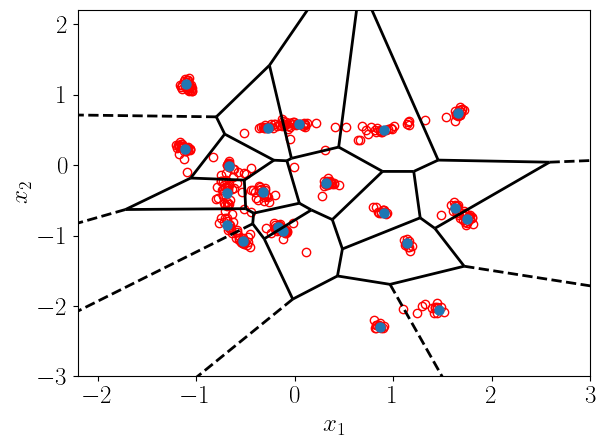

<Figure size 640x480 with 0 Axes>

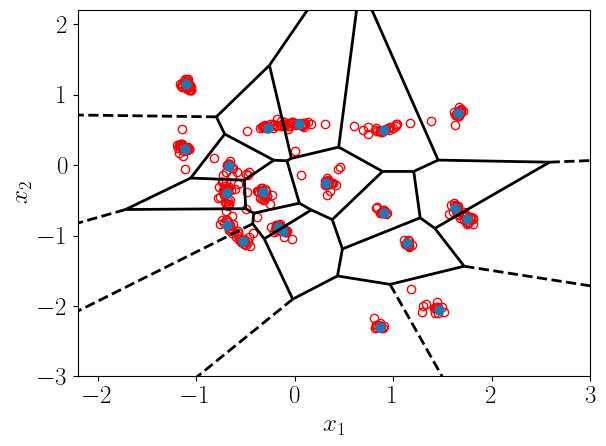

<Figure size 640x480 with 0 Axes>

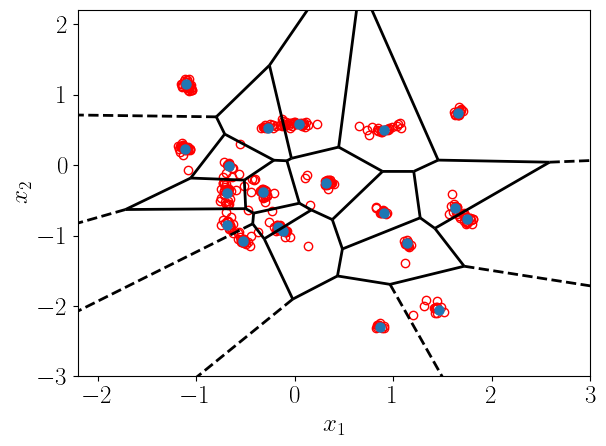

<Figure size 640x480 with 0 Axes>

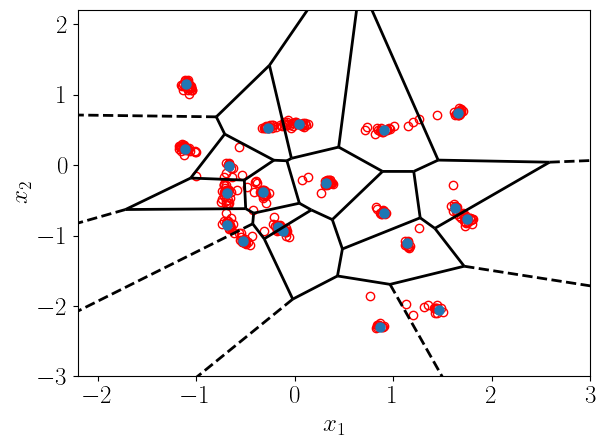

<Figure size 640x480 with 0 Axes>

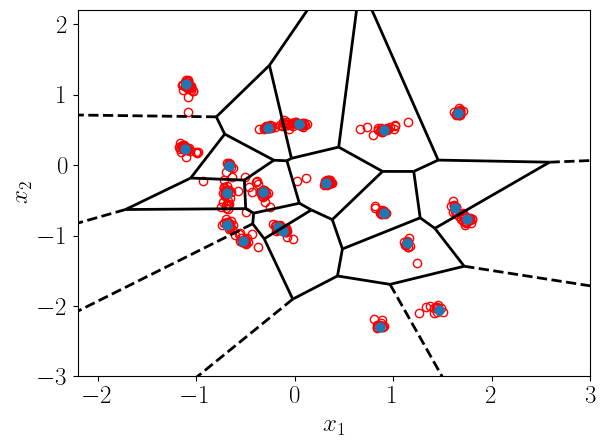

<Figure size 640x480 with 0 Axes>

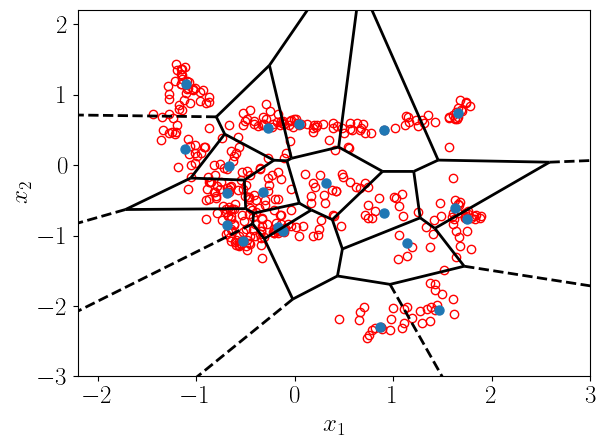

<Figure size 640x480 with 0 Axes>

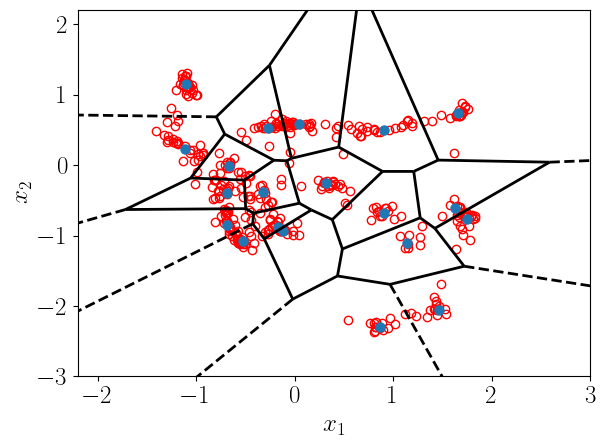

<Figure size 640x480 with 0 Axes>

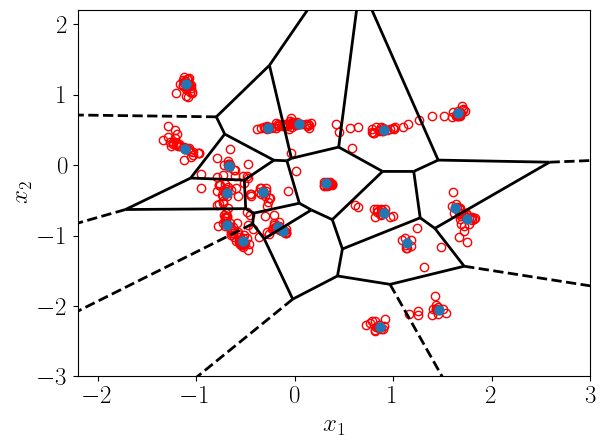

<Figure size 640x480 with 0 Axes>

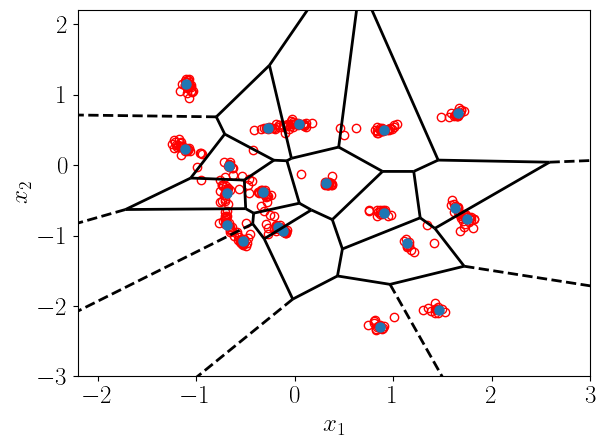

<Figure size 640x480 with 0 Axes>

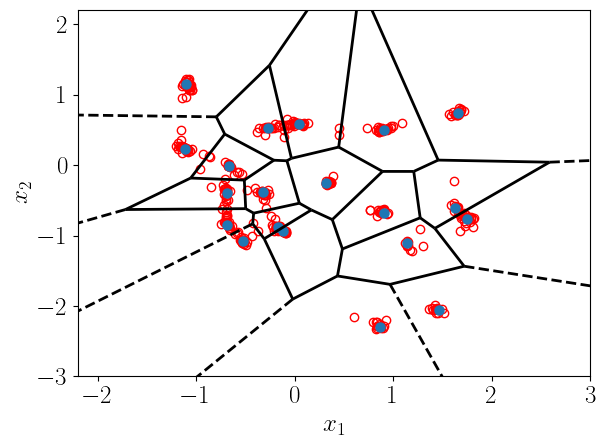

<Figure size 640x480 with 0 Axes>

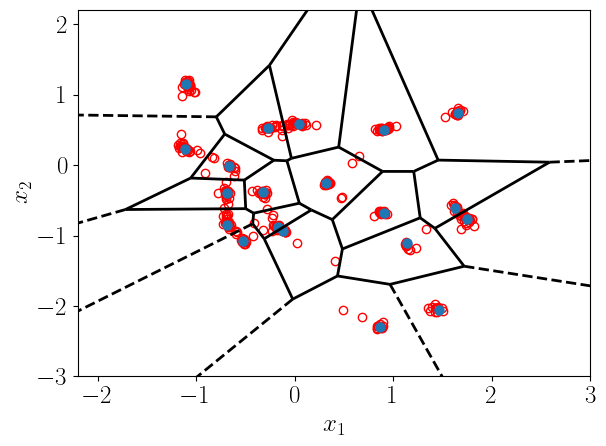

<Figure size 640x480 with 0 Axes>

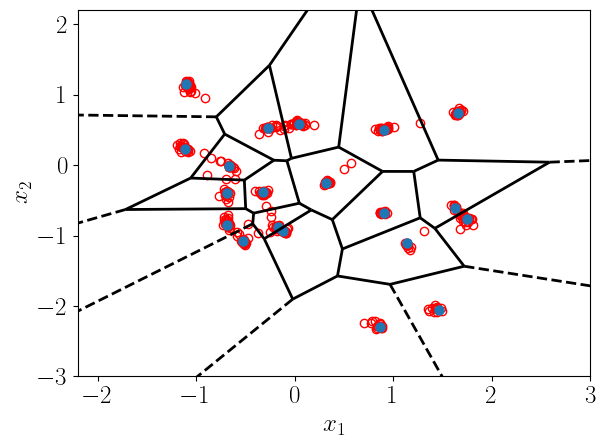

<Figure size 640x480 with 0 Axes>

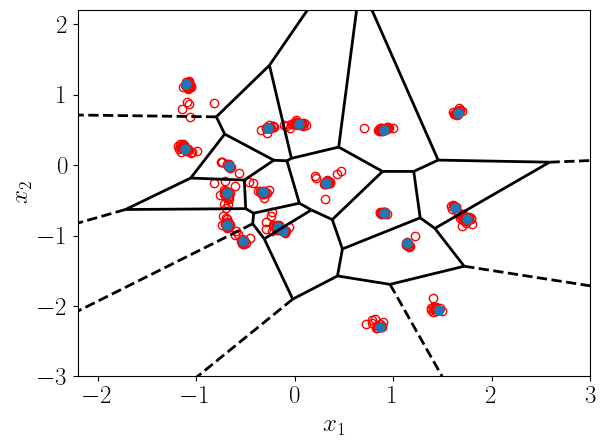

<Figure size 640x480 with 0 Axes>

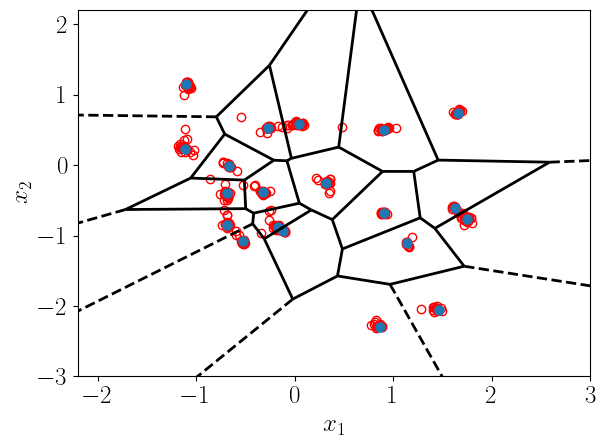

<Figure size 640x480 with 0 Axes>

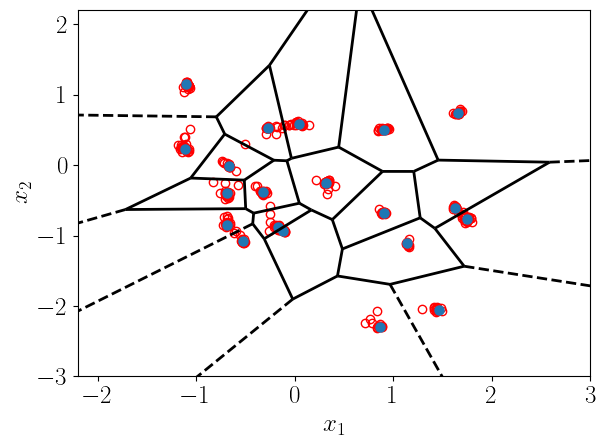

In [21]:
# define latents for sampling and integrate model
batch_size = 1000
latents = torch.randn(batch_size, dim)

# define points for plotting
plotting_pts = 400

# define network names 
network_names = ['nonsingular','singular']

# epoch for plotting
epoch_plotting = np.arange(plot_every-1, n_epochs, plot_every)

# Define network
score_net = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
score_ema = EMA(score_net, beta=0.9999)

for network in network_names:
    for epoch in epoch_plotting:
        # load model
        score_ema.load_state_dict(torch.load(path_to_save+network+'_checkpoint_'+str(epoch)+'.pth')[1])
        if network == 'singular':
            score_ema.online_model.training_mode = False
            score_ema.ema_model.training_mode    = False
            score_ema.online_model.schedule      = schedule
            score_ema.ema_model.schedule         = schedule
        # integrate model
        samples_t, samples_x = schedule.ODEsampler(score_ema, latents, T0=1.0, T1=0.)
        # extract final samples
        lat_shape = [batch_size, 2, len(samples_t)]
        res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)
        final_samples = res_loc[:,:,-1]
        # plot generated samples
        plt.figure()
        fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, point_size=13)
        plt.plot(final_samples[:plotting_pts,0], final_samples[:plotting_pts,1], 'or', mfc='none', zorder=0)
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.xlim(-2.2,3)
        plt.ylim(-3,2.2)
        #plt.title(network + ': epoch' + str(epoch))
        plt.tight_layout()
        plt.savefig(figures_path+network+'_epoch'+str(epoch)+'.pdf')


In [20]:
# define tolerances
tol_list = [1e-2, 5e-2, 1e-1, 5e-1]

# define array to store counts
count_data = np.zeros((len(tol_list), len(network_names), len(epoch_plotting)))

# Define network
score_net = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
score_ema = EMA(score_net, beta=0.9999)

for (k,network) in enumerate(network_names):
    for (l,epoch) in enumerate(epoch_plotting):
        # load model
        score_ema.load_state_dict(torch.load(path_to_save+network+'_checkpoint_'+str(epoch)+'.pth')[1])
        if network == 'singular':
            score_ema.online_model.training_mode = False
            score_ema.ema_model.training_mode    = False
            score_ema.online_model.schedule      = schedule
            score_ema.ema_model.schedule         = schedule
        # integrate model
        samples_t, samples_x = schedule.ODEsampler(score_ema, latents, T0=1.0, T1=0.)
        # extract final samples
        lat_shape = [batch_size, 2, len(samples_t)]
        res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)
        final_samples = res_loc[:,:,-1]
        # check how close each point is to a data point
        for (j,tolerance) in enumerate(tol_list):
            count = 0
            for i in range(batch_size):
                dist = torch.sqrt(torch.sum((final_samples[i,:] - torch.tensor(data, dtype=torch.float32))**2, axis=1))
                if torch.min(dist) < tolerance:
                    count += 1
            count_data[j,k,l] = count/batch_size

    print(network)
    print(count_data[:,k,:])

/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_36601/2190557586.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)
/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_36601/2190557586.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.sqrt(torch.sum((final_samples[i,:] - torch.tensor(data, dtype=torch.float32))**2, axis=1))


nonsingular
[[0.    0.006 0.01  0.018 0.022 0.027 0.04  0.048 0.05  0.049]
 [0.04  0.08  0.17  0.267 0.361 0.426 0.489 0.539 0.576 0.617]
 [0.131 0.249 0.416 0.531 0.641 0.721 0.769 0.801 0.84  0.864]
 [0.957 0.991 0.996 0.999 0.998 0.999 1.    0.998 1.    0.999]]
singular
[[0.002 0.015 0.029 0.039 0.071 0.08  0.085 0.097 0.118 0.138]
 [0.072 0.214 0.36  0.48  0.555 0.638 0.696 0.736 0.767 0.81 ]
 [0.225 0.475 0.657 0.752 0.816 0.861 0.883 0.907 0.919 0.938]
 [0.986 0.996 0.998 1.    1.    1.    1.    0.999 1.    1.   ]]


## Plot score functions

In [ ]:
# define plotting location
idx = 0
x_pt_ = data[idx,:].reshape(1,2)
x_pt = x_pt_ + 0.1*torch.randn_like(x_pt_)
t_pts = 10**np.linspace(-5,0,100)
t_pts = torch.tensor(t_pts, device=device, dtype=torch.float32)
t_pts = torch.cat([torch.tensor([0.0], device=device, dtype=torch.float32),t_pts])
t_pts = t_pts[:,None]
x_pt2 = x_pt.repeat(t_pts.shape[0],1).to(device)

# Define network
score_net = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
score_ema = EMA(score_net, beta=0.9999)

for (kk,reg_strength) in enumerate(reg_strength_vect):

    # load model
    score_ema.load_state_dict(torch.load(path_to_save+'regstrength'+str(reg_strength)+'_checkpoint_'+str(epoch)+'.pth')[1])

    # evaluate the learned score function and GMM score
    score_learn = score_net(x_pt2, t_pts)
    score_learn_norm = torch.zeros(t_pts.shape[0])
    score_true_norm = torch.zeros(t_pts.shape[0])
    gmm_train = GMM_score(torch.tensor(data, dtype=torch.float32), schedule.marginal_prob_mean, schedule.marginal_prob_std)
    score_gmm_norm = torch.zeros(t_pts.shape[0])

    for i in range(t_pts.shape[0]):
        score_learn_norm[i] = torch.norm(score_learn[i]).detach().cpu() 
        sigma = schedule.marginal_prob_std(t_pts[i]) + 1.0
        score_true_norm[i] = torch.norm( -1*(x_pt.to(device) - x_pt_.to(device))/sigma**2).detach().cpu()
        score_gmm = gmm_train(x_pt.detach().cpu(), t_pts[i].detach().cpu())
        score_gmm_norm[i] = torch.norm(score_gmm).detach().cpu()

    plt.figure()
    plt.plot(t_pts.cpu().numpy(), score_learn_norm.cpu().numpy(), '-r', label='Learned score')
    plt.plot(t_pts.cpu().numpy(), score_gmm_norm.cpu().numpy(), '-g', label='GMM score')
    plt.ylabel(r'$|| \nabla_{x} \log p(x_t, t) ||_2$')
    plt.yscale('log')
    plt.xlim(0,1.0)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.title(reg_strength)
    plt.savefig(figures_path+'regstrength'+str(reg_strength)+'.pdf')